<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import sys
sys.path.append('../../')

import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from tslearn.datasets import UCR_UEA_datasets
from sklearn import svm
import signature_features
from signature_features import *
import utils
from utils import *
import experiments
from experiments import * 
from sklearn.metrics import accuracy_score
# import gpflow
from sklearn.preprocessing import LabelEncoder
from scipy.io import arff

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

In [25]:
data_train = arff.loadarff('Multivariate_arff/AtrialFibrillation/AtrialFibrillation_TRAIN.arff')
data_test = arff.loadarff('Multivariate_arff/AtrialFibrillation/AtrialFibrillation_TEST.arff')

df_train = pd.DataFrame(data_train[0])
df_test = pd.DataFrame(data_test[0])

labels_train = df_train.iloc[:,1]
labels_test = df_test.iloc[:,1]

y_train = LabelEncoder().fit_transform(labels_train)
y_test = LabelEncoder().fit_transform(labels_test)

x_train = [np.array(a.tolist()).T for a in df_train.iloc[:,0]]
x_test = [np.array(a.tolist()).T for a in df_test.iloc[:,0]]

In [26]:
df_train.head()

,ECG_Atrial_Fibrilation,target
0,"[[-0.34086, -0.38038, -0.3458, -0.36556, -0.34...",b'n'
1,"[[-0.11362, -0.0741, -0.05928, -0.10374, -0.14...",b'n'
2,"[[-0.2079, -0.1683, -0.198, -0.1584, -0.2079, ...",b'n'
3,"[[-0.11805, -0.08657, -0.09444, -0.05509, -0.0...",b'n'
4,"[[-0.11362, -0.06422, -0.05928, -0.03952, -0.0...",b'n'


In [27]:
df_train.iloc[:,1].unique()

array([b'n', b's', b't'], dtype=object)

In [28]:
def transform(paths, scale=1.):
    return [scale*p for p in paths]

In [29]:
x_train = np.array(transform(x_train))
x_test = np.array(transform(x_test))
l = x_train.shape[1]

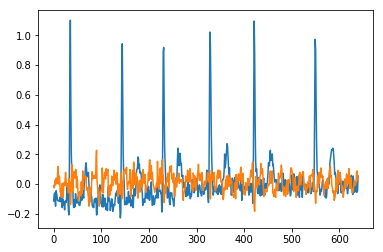

In [30]:
plt.plot(x_train[1])
plt.show()

In [31]:
x_train.shape

(15, 640, 2)

In [32]:
x_test.shape

(15, 640, 2)

In [81]:
X_aug_train =  np.concatenate([np.concatenate(np.array_split(e[None,:,:],10,axis=1))[None,:,:,:] for e in x_train])
X_aug_test =  np.concatenate([np.concatenate(np.array_split(e[None,:,:], 10,axis=1))[None,:,:,:] for e in x_test])

# X_aug_train = utils.add_dimension(X_aug_train,add_time=True,lead_lag=None)
# X_aug_test = utils.add_dimension(X_aug_test,add_time=True,lead_lag=None)

# X_aug_train = utils.add_dimension(X_aug_train,add_time=False,lead_lag=1)
# X_aug_test = utils.add_dimension(X_aug_test,add_time=False,lead_lag=1)

In [82]:
print(X_aug_train.shape)

(15, 10, 64, 2)


**Sig KME**

In [83]:
reload(experiments)
reload(signature_features)

sig_level = 2

# Compute the expected signature
X_feat_train = signature_features.scaled_expected_sig([e.copy() for e in X_aug_train],sig_level)
X_feat_test = signature_features.scaled_expected_sig([e.copy() for e in X_aug_test],sig_level)

# scale the features
scaler = StandardScaler()
to_fit = X_feat_train
scaler.fit(to_fit)
X_feat_train = scaler.transform(X_feat_train)
X_feat_test = scaler.transform(X_feat_test)

In [84]:
# kernel = 10*RBF(1) + WhiteKernel(noise_level=0.01)
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_feat_train, y_train)
# gpc.score(X_feat_test, y_test)

In [85]:
results_penalty = []
for p in np.linspace(0.1, 10, 50):
    clf = svm.SVC(kernel='rbf',gamma='auto',C=p,decision_function_shape='ovr')
    clf = clf.fit(X_feat_train,y_train)
    results_penalty.append(clf.score(X_feat_test, y_test))

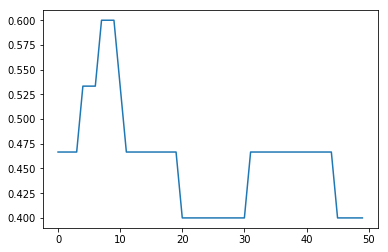

In [86]:
plt.plot(results_penalty)

In [87]:
max(results_penalty)

0.6

**Pathwise E-Sig**

In [92]:
# specs for pathwise expected sig
sig_level1 = 2

# specs for signature
sig_level2 = 2

# pathwise expected sig  
X_feat_train = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug_train],sig_level1)
X_feat_train = iisignature.sig(X_feat_train,sig_level2)

X_feat_test = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug_test],sig_level1)
X_feat_test = iisignature.sig(X_feat_test,sig_level2)

scaler = StandardScaler()
to_fit = [X_feat_train[i] for i in range(len(X_feat_train))]
scaler.fit(to_fit)
X_feat_train = scaler.transform(X_feat_train)
X_feat_test = scaler.transform(X_feat_test)

In [93]:
# kernel = DotProduct() #+ WhiteKernel(0.1)
# #kernel = 1.0 * RBF(10)
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=0,multi_class='one_vs_one').fit(X_feat_train, y_train)
# print(gpc.score(X_feat_test, y_test))
# print(gpc.kernel.theta)

kernel = DotProduct()+ WhiteKernel(0.1)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0)
gpc = gpc.fit(X_feat_train, y_train)
print(gpc.score(X_feat_test, y_test))
# print(np.exp(gpc.kernel_.theta))

0.4


In [156]:
clf = svm.SVC(kernel='linear',gamma=0.01,C=1000,decision_function_shape='ovo')
clf = clf.fit(X_feat_train,y_train)
clf.score(X_feat_test, y_test)

0.75

In [590]:
def random_subsampling(X_train,X_test,N_obs,N_samples):
    subsampling = []
    for i in range(N_samples):
        choice_obs = np.random.choice(np.arange(X_train.shape[1]), size=N_obs, replace=False)
        choice_obs = np.sort(choice_obs)
        subsampling.append(choice_obs)
    
    X_aug_train = np.concatenate([np.concatenate([e[subsampling[i],:][None,:,:] for i in range(N_samples)])[None,:,:,:] for e in X_train])   
    X_aug_test = np.concatenate([np.concatenate([e[subsampling[i],:][None,:,:] for i in range(N_samples)])[None,:,:,:] for e in X_test])
    return X_aug_train, X_aug_test

def random_subseries(X_train,X_test,N_sub,L):
    subsampling = []
    for i in range(len(X_train)+len(X_test)):
        choice_obs = np.random.choice(np.arange(X_train.shape[1]-L), size=N_sub, replace=False)
        choice_obs = np.sort(choice_obs)
        subsampling.append(choice_obs)
    
    X_aug_train = np.concatenate([np.concatenate([e[subsampling[j][i]:subsampling[j][i]+L,:][None,:,:] for i in range(N_sub)])[None,:,:,:] for j,e in enumerate(X_train)])   
    X_aug_test = np.concatenate([np.concatenate([e[subsampling[j][i]:subsampling[j][i]+L,:][None,:,:] for i in range(N_sub)])[None,:,:,:] for j,e in enumerate(X_test)]) 
    return X_aug_train, X_aug_test
